# Import Libraries & Dataset

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [130]:
df = pd.read_csv("rental_info.csv")
display(df.head())
df.info()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.00,2.99,126.00,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.94,15876.00,8.94
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.00,2.99,126.00,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.94,15876.00,8.94
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.00,2.99,126.00,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.94,15876.00,8.94
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.00,2.99,126.00,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.94,15876.00,8.94
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.00,2.99,126.00,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.94,15876.00,8.94


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


# Preprocessing

In [131]:
# Convert dates to datetime format
df["rental_date"] = pd.to_datetime(df["rental_date"])
df["return_date"] = pd.to_datetime(df["return_date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

Create a column that contains information on how many days a DVD has been rented by a customer.

In [132]:
# Create rental_lenth_days
df["rental_length_days"] = (df["return_date"] - df["rental_date"]).dt.days

df[["return_date", "rental_date", "rental_length_days"]].head()

,return_date,rental_date,rental_length_days
0,2005-05-28 23:40:33+00:00,2005-05-25 02:54:33+00:00,3
1,2005-06-18 19:24:16+00:00,2005-06-15 23:19:16+00:00,2
2,2005-07-17 10:11:45+00:00,2005-07-10 04:27:45+00:00,7
3,2005-08-02 14:30:41+00:00,2005-07-31 12:06:41+00:00,2
4,2005-08-23 13:35:04+00:00,2005-08-19 12:30:04+00:00,4


Create two columns of dummy variables from `"special_features"`, which takes the value of `1` when:
- The value is `"Deleted Scenes"`, storing as a column called `"deleted_scenes"`.
- The value is `"Behind the Scenes"`, storing as a column called `"behind_the_scenes"`.

In [133]:
# Create Dummy Variables for special_features
df["deleted_scenes"] = df["special_features"].apply(lambda x: 1 if "Deleted Scenes" in x else 0)
df["behind_the_scenes"] = df["special_features"].apply(lambda x: 1 if "Behind the Scenes" in x else 0)

df[["special_features", "deleted_scenes", "behind_the_scenes"]].head()

,special_features,deleted_scenes,behind_the_scenes
0,"{Trailers,""Behind the Scenes""}",0,1
1,"{Trailers,""Behind the Scenes""}",0,1
2,"{Trailers,""Behind the Scenes""}",0,1
3,"{Trailers,""Behind the Scenes""}",0,1
4,"{Trailers,""Behind the Scenes""}",0,1


# Modeling

## Split Train & Test

Split the data into `X_train`, `y_train`, `X_test`, and `y_test` train and test sets, avoiding any features that leak data about the target variable, and include 20% of the total data in the test set.

In [134]:
# Prepare Feature Matrix X and Target y
# Select features excluding columns that leak target info
X = df.drop(columns=["rental_date", "return_date", "special_features", "rental_length_days"])
y = df["rental_length_days"]

display(X)
display(y)

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,deleted_scenes,behind_the_scenes
0,2.99,2005.00,2.99,126.00,16.99,0,0,0,1,8.94,15876.00,8.94,0,1
1,2.99,2005.00,2.99,126.00,16.99,0,0,0,1,8.94,15876.00,8.94,0,1
2,2.99,2005.00,2.99,126.00,16.99,0,0,0,1,8.94,15876.00,8.94,0,1
3,2.99,2005.00,2.99,126.00,16.99,0,0,0,1,8.94,15876.00,8.94,0,1
4,2.99,2005.00,2.99,126.00,16.99,0,0,0,1,8.94,15876.00,8.94,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15856,6.99,2009.00,4.99,88.00,11.99,0,0,0,1,48.86,7744.00,24.90,1,1
15857,4.99,2009.00,4.99,88.00,11.99,0,0,0,1,24.90,7744.00,24.90,1,1
15858,8.99,2009.00,4.99,88.00,11.99,0,0,0,1,80.82,7744.00,24.90,1,1
15859,7.99,2009.00,4.99,88.00,11.99,0,0,0,1,63.84,7744.00,24.90,1,1


0        3
1        2
2        7
3        2
4        4
        ..
15856    6
15857    4
15858    9
15859    8
15860    6
Name: rental_length_days, Length: 15861, dtype: int64

In [135]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=9
)

## Model with LazyRegressor

In [136]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=mean_squared_error)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|██▏       | 9/42 [00:02<00:09,  3.30it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 12688, number of used features: 14
[LightGBM] [Info] Start training from score 4.529950


In [137]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_squared_error
Model,,,,,
XGBRegressor,0.73,0.73,1.38,0.10,1.91
RandomForestRegressor,0.71,0.71,1.43,2.26,2.03
ExtraTreesRegressor,0.71,0.71,1.43,1.53,2.04
LGBMRegressor,0.71,0.71,1.43,0.10,2.05
HistGradientBoostingRegressor,0.71,0.71,1.44,0.22,2.06
BaggingRegressor,0.71,0.71,1.44,0.24,2.08
GaussianProcessRegressor,0.69,0.70,1.47,16.80,2.16
ExtraTreeRegressor,0.69,0.69,1.47,0.03,2.17
DecisionTreeRegressor,0.69,0.69,1.48,0.04,2.18


## Model with XGBRegressor (Best Model)

In [138]:
from xgboost import XGBRegressor

# Best model
best_model = XGBRegressor(random_state=9)

# Train the model
best_model.fit(X_train, y_train)

# Predictions on test set
y_pred = best_model.predict(X_test)

## R-Squared

In [139]:
# r_squared
r_squared_xgb = r2_score(y_test, y_pred)
print(f"R Squared: {r_squared_xgb}")

R Squared: 0.7315512895584106


This R-Squared result means that **0.732** (or about **73%**) of the variation in the length of movie rental duration can be explained by the linear relationship between independent variables (predictors) and the dependent variable (rental duration).

The remaining **27%** of the variation is not explained by this model and could be due to other factors not included in the analysis or some level of randomness (unexplained variation).

## MSE

In [140]:
# MSE
mse_xgb = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse_xgb}")

Mean Squared Error: 1.9058708283906145


On the other hand, an MSE of **1.91** means that, on average, the square of the differences between the observed and predicted values of movie rental durations is about **1.91**.

Let's check the summary statistics of the dependent variable to compare the MSE result with the standard deviation.

In [141]:
df['rental_length_days'].describe()

count   15861.00
mean        4.53
std         2.64
min         0.00
25%         2.00
50%         5.00
75%         7.00
max         9.00
Name: rental_length_days, dtype: float64

The MSE value of **1.91** is relatively close to the standard deviation (**2.64**). This suggests that, on average, the model's predictions are off by roughly **1.91** days, which is about **73%** of the standard deviation of the rental lengths.

Note that the **73%** in the context of the Mean Squared Error (MSE) is not the same as the R-squared (R²) value. The **73%** of standard deviation for the MSE refers to how close the MSE is to the standard deviation of the data (**2.64**). This shows that the model's prediction errors are about **73%** as large as the spread of the data itself. But this is a different concept from R-squared, which is about **how much of the variance** in the data is explained by the model.

Considering the range of rental durations is from 0 to 9 days, an MSE of **1.91** indicates that the model’s predictions are somewhat reasonable but not perfect. The model may still have some room for improvement, as it's capturing some but not all of the variability in the data.

## Residual Plot

Let's plot the Residual Plot. This plot helps us evaluate whether the regression model is a good fit for the data and making unbiased predictions. It also helps us check whether the variance of errors remains constant across all predicted values (homoscedasticity).

A good model should have residuals randomly scattered around zero, with no clear pattern. If we see patterns (e.g., funnel shape, U-shape), it may indicate problems like missing features, heteroscedasticity, or non-linearity in the data.

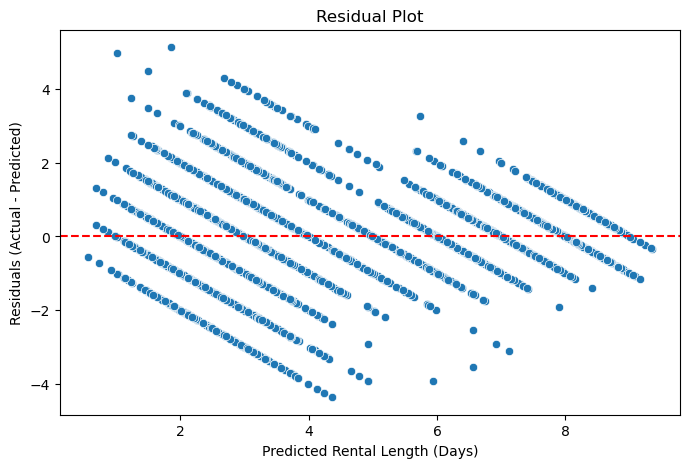

In [142]:
# Residuals (errors)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color="r", linestyle="--")  # Reference line at 0
plt.xlabel("Predicted Rental Length (Days)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

The residual plot shows a structured pattern with diagonal lines rather than being randomly scattered, indicating that the regression model may not be fully capturing the relationship in the data. The presence of diagonal bands suggests the target variable is discrete, and the variation in residual spread hints at heteroscedasticity. This means the model might not be the best fit for the dataset.

## Actual vs. Predicted Plot

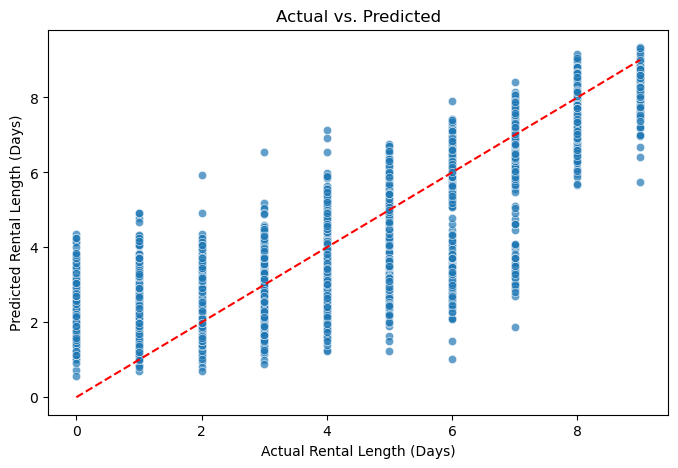

In [143]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # Perfect prediction line
plt.xlabel("Actual Rental Length (Days)")
plt.ylabel("Predicted Rental Length (Days)")
plt.title("Actual vs. Predicted")
plt.show()


In this Actual vs. Predicted Plot, the predictions follow a general upward trend, meaning the model **captures the relationship** between the features and rental length. However, **there is noticeable vertical dispersion**, meaning the model has difficulty making precise predictions, especially for higher rental lengths.

The **banded structure** suggests that the target variable is **discrete (integer values)**, meaning that customers mostly rent for whole days. There are **predictions above and below the red line**, meaning some values are underpredicted and others are overpredicted.

The trend follows the expected pattern (higher actual rental lengths correspond to higher predicted values). But there are some potential issues:
- Some points deviate significantly from the red line, suggesting errors in prediction.
- The **vertical spread at each actual rental length** means the model struggles to predict exact values.

## Distribution of Residuals Plot

Let's see the Distribution of Residuals plot.

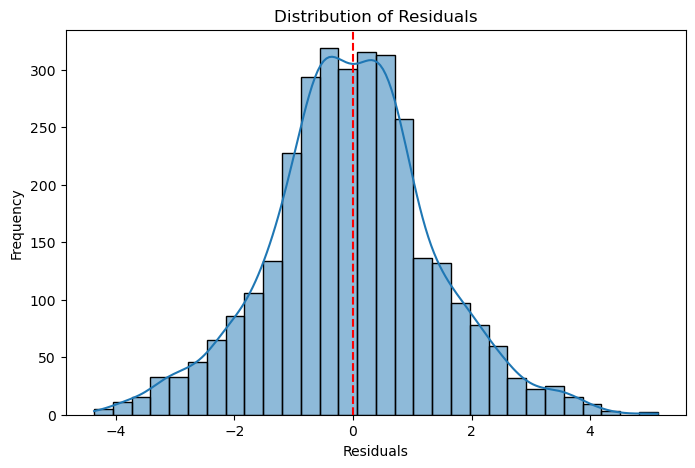

In [144]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color="r", linestyle="--")  # Reference line at 0
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


We can see that the residuals follow a **roughly normal distribution**, which is a good sign. The peak at **0** suggests that many predictions are close to the actual values. The **slight right skew** (more positive residuals) suggests that the model tends to **underpredict** rental length slightly. And there are also **some large residuals (outliers)**, meaning some predictions are quite far off or some extreme values are predicted inaccurately.

## Feature Importance

Let's check the feature importance in the dataset to check how much each feature (independent variable) contributes to the prediction of the dependent variable in a model.

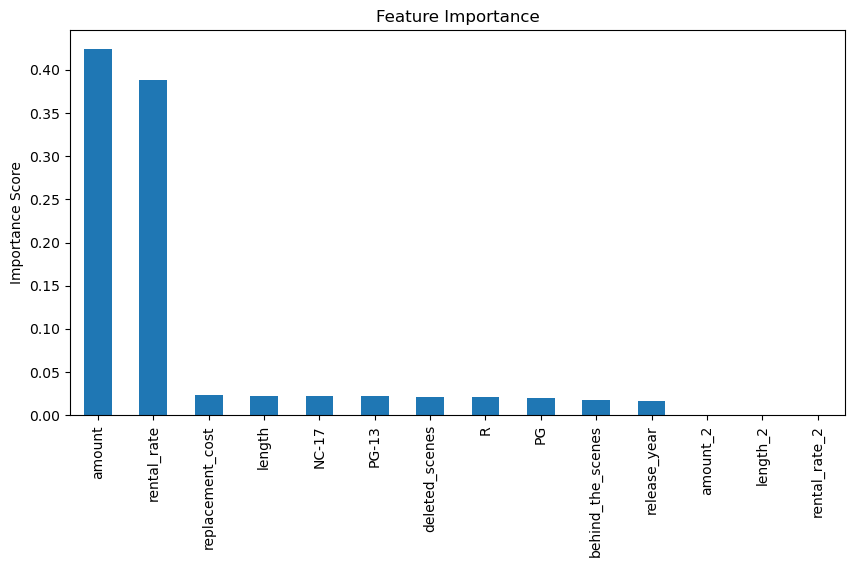

In [145]:
if hasattr(best_model, "feature_importances_"):  # Only for tree-based models
    feature_importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5))
    plt.ylabel("Importance Score")
    plt.title("Feature Importance")
    plt.show()

We can see that the features `amount` and `rental_rate` have the higher importance scores compared to the other features. The ≈**0.40** importance score means that the feature explains **40%** of the model's prediction in relation to all the features used in the model.

This indicates that these features have a relatively significant influence on the prediction of the rental duration (the dependent variable). These features are likely to be one of the primary predictors for the rental length, and it explains a considerable portion of the variation in the rental duration.